In [511]:
import pandas as pd
import numpy as np
import random
import copy
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.preprocessing import Normalizer

In [990]:
class myNN():
    def __init__(self, architecture, learning_rate):
        self.architecture = architecture
        self.learning_rate = learning_rate
        self.params = {}
        self.init_layers()
        
    def init_layers(self):
        np.random.seed(99)
        for index, layer in enumerate(self.architecture):
            layer_index = index + 1
            layer_input_size = layer['input_dim']
            layer_output_size = layer['output_dim']
            self.params['W' + str(layer_index)] = np.random.randn(layer_output_size, layer_input_size)*0.1
            self.params['b' + str(layer_index)] = np.random.randn(layer_output_size, 1)*0.1
            #print(self.params['W'+str(layer_index)].shape)
            #print(self.params['W'+str(layer_index)])
            #print(self.params['b'+str(layer_index)])
            #print("*******")
            
    def sigmoid(self, Z):
        return 1/(1+np.exp(-Z))
    
    def relu(self, Z):
        return np.maximum(0,Z)
    
    def linear(self, Z):
        return Z
    
    def sigmoid_backward(self, dA, Z):
        sig = self.sigmoid(Z)
        return dA*sig*(1-sig)
    
    def relu_backward(self, dA, Z):
        dZ = np.array(dA, copy = True)
        dZ[Z<=0] = 0
        return dZ
    
    def linear_backward(self, dA, Z):
        return dA
    
    def single_layer_FP(self, A_prev, W_curr, b_curr, activation='relu'):
        #print(W_curr.shape)
        #print(A_prev.shape)
        Z_curr = np.dot(W_curr, A_prev) + b_curr
        #print(Z_curr.shape)
        #print("------")
        if activation == 'relu':
            activation_func = self.relu
        elif activation == 'sigmoid':
            activation_func = self.sigmoid
        elif activation == 'linear':
            activation_func = self.linear
        else:
            raise Exception('Non-supported activation function')
        return activation_func(Z_curr), Z_curr
    
    def forward_propagation(self, x):
        memory = {}
        A_curr = x
        for index, layer in enumerate(self.architecture):
            layer_index = index + 1
            A_prev = A_curr
            activation_func = layer['activation']
            W_curr = self.params['W'+str(layer_index)]
            b_curr = self.params['b'+str(layer_index)]
            A_curr, Z_curr = self.single_layer_FP(A_prev, W_curr, b_curr, activation_func)
            memory["A"+str(index)] = A_prev
            memory["Z"+str(layer_index)] = Z_curr
        return A_curr, memory
        
    def get_loss_value(self, y, y_predict):
        #delta = y - y_predict
        #loss = np.dot(delta, delta.T)
        #return np.squeeze(loss)
        return np.power(y_predict - y, 2).mean()
    
    def single_layer_BP(self, dA_curr, W_curr, b_curr, Z_curr, A_prev, activation='relu'):
        if activation == 'relu':
            activation_func = self.relu_backward
            dZ_curr = activation_func(dA_curr, Z_curr)
        elif activation == 'sigmoid':
            activation_func = self.sigmoid_backward
        elif activation == 'linear':
            activation_func = self.linear_backward
            dZ_curr = activation_func(dA_curr, Z_curr)
        else:
            raise Exception('Non-supported activation function')
        dW_curr = np.dot(dZ_curr, A_prev.T)
        db_curr = np.sum(dZ_curr, axis=1, keepdims=True)
        dA_prev = np.dot(W_curr.T, dZ_curr)
        return dA_prev, dW_curr, db_curr
    
    def back_propagation(self, y_predict, y, memory):
        grads_values = {}
        dA_prev = 2*(y_predict-y)
        #dA_prev = delta * np.ones(y.shape).reshape(1,-1)
        for layer_prev_index, layer in reversed(list(enumerate(self.architecture))):
            layer_cur_index = layer_prev_index+1
            activation_func = layer['activation']
            dA_curr = dA_prev
            A_prev = memory['A' + str(layer_prev_index)]
            Z_curr = memory['Z' + str(layer_cur_index)]
            W_curr = self.params['W'+str(layer_cur_index)]
            b_curr = self.params['b'+str(layer_cur_index)]
            dA_prev, dW_curr, db_curr = self.single_layer_BP(dA_curr, W_curr, b_curr, Z_curr, A_prev, activation_func)
            grads_values['dW'+str(layer_cur_index)] = dW_curr
            grads_values['db'+str(layer_cur_index)] = db_curr
        return grads_values
    
    def update(self, grads_values):
        for index, layer in enumerate(self.architecture):
            layer_idx = index + 1
            self.params["W" + str(layer_idx)] -= learning_rate * grads_values["dW" + str(layer_idx)]        
            self.params["b" + str(layer_idx)] -= learning_rate * grads_values["db" + str(layer_idx)]
    
    def train(self, x, y, epochs, batch_size=16):
        loss_history = []
        for i in range(epochs):
            x, y = shuffle(x, y)
            for i in range(0 ,x.shape[1], batch_size):
                x_min = x[i:i + batch_size]
                y_min = y[i:i + batch_size]
                y_predict, memory = self.forward_propagation(x_min.T)
                loss = self.get_loss_value(np.array([y_min]), y_predict)
                grads_values = self.back_propagation(y_predict, np.array([y_min]), memory)
                self.update(grads_values)
            #y_predict, memory = self.forward_propagation(x.T)
            #loss = self.get_loss_value(np.array([y]), y_predict)
            #grads_values = self.back_propagation(y_predict, np.array([y]), memory)
            #self.update(grads_values)
            y_predict, memory = self.forward_propagation(x.T)
            loss = self.get_loss_value(np.array([y]), y_predict)
            print("the loss %lf" % loss)
            loss_history.append(loss)
        return loss_history
    
    def show_parm(self):
        print(self.params)
    
    def predict(self, x):
        y_predict, memory = self.forward_propagation(x)
        return y_predict

In [1002]:
# https://www.itread01.com/feffx.html
# https://towardsdatascience.com/lets-code-a-neural-network-in-plain-numpy-ae7e74410795
nn_architecture = [
    {"input_dim": 16, "output_dim": 32, "activation": "relu"},
    {"input_dim": 32, "output_dim": 16, "activation": "relu"},
    {"input_dim": 16, "output_dim": 8, "activation": "relu"},
    {"input_dim": 8, "output_dim": 4, "activation": "relu"},
    #{"input_dim": 8, "output_dim": 4, "activation": "sigmoid"},
    {"input_dim": 4, "output_dim": 1, "activation": "linear"},
]
learning_rate = 0.000001

In [1003]:
# Orientation category : 2, 3, 4, 5
# Glazing Area Distribution : 0, 1, 2, 3, 4, 5
data = pd.read_csv('energy_efficiency_data.csv')
heating = data.pop('Heating Load')
cooling = data.pop('Cooling Load')

In [1004]:
# for one hot encoding
Orient = pd.get_dummies(data['Orientation'])
Glazing = pd.get_dummies(data['Glazing Area Distribution'])
data = pd.concat([data,pd.get_dummies(data['Orientation'], prefix='Orientation')],axis=1)
data = pd.concat([data,pd.get_dummies(data['Glazing Area Distribution'], prefix='Glazing Area Distribution')],axis=1)
data.drop(['Orientation'],axis=1, inplace=True)
data.drop(['Glazing Area Distribution'],axis=1, inplace=True)

In [1005]:
# split data
#data = Normalizer(norm='l1').fit_transform(data)
X_train, X_test, y_train, y_test = train_test_split(data.to_numpy(), heating.to_numpy(), test_size=0.25, random_state=42)

In [1006]:
model = myNN(nn_architecture, learning_rate)

In [1007]:
model.train(X_train, np.array(y_train), 1000, batch_size=8)
print("finish")

the loss 589.622487
the loss 587.050842
the loss 584.323361
the loss 581.531676
the loss 578.272687
the loss 575.309833
the loss 572.097094
the loss 568.627273
the loss 564.764630
the loss 560.857364
the loss 556.763913
the loss 551.945050
the loss 548.010764
the loss 542.519537
the loss 537.364704
the loss 530.264556
the loss 523.038620
the loss 515.212289
the loss 504.430255
the loss 493.594615
the loss 483.668784
the loss 471.361759
the loss 456.737497
the loss 439.301859
the loss 423.272770
the loss 402.782845
the loss 381.499126
the loss 359.190108
the loss 330.313224
the loss 305.967386
the loss 277.884714
the loss 246.439738
the loss 209.330526
the loss 189.084254
the loss 166.891755
the loss 144.004241
the loss 135.198758
the loss 138.073775
the loss 131.690645
the loss 130.615691
the loss 129.511569
the loss 129.165706
the loss 129.769116
the loss 128.948939
the loss 128.902422
the loss 128.604049
the loss 129.004396
the loss 129.433066
the loss 130.000456
the loss 128.378577


the loss 32.432016
the loss 35.609667
the loss 40.436254
the loss 34.621343
the loss 43.360554
the loss 35.729801
the loss 32.367338
the loss 32.570471
the loss 32.576391
the loss 38.695398
the loss 32.146448
the loss 36.164384
the loss 33.579030
the loss 32.953342
the loss 37.981361
the loss 32.308113
the loss 43.032666
the loss 32.421130
the loss 42.928863
the loss 32.538476
the loss 49.647958
the loss 32.131011
the loss 47.453711
the loss 33.119438
the loss 35.371655
the loss 38.422533
the loss 32.451780
the loss 41.405989
the loss 35.474241
the loss 32.164683
the loss 36.453092
the loss 32.121078
the loss 32.322325
the loss 32.317030
the loss 34.265685
the loss 33.471096
the loss 34.391768
the loss 41.743766
the loss 35.510001
the loss 33.958270
the loss 32.548282
the loss 40.125317
the loss 36.468866
the loss 33.839690
the loss 36.744134
the loss 34.899492
the loss 39.207258
the loss 35.442121
the loss 32.770663
the loss 41.692245
the loss 32.284475
the loss 33.687110
the loss 32.

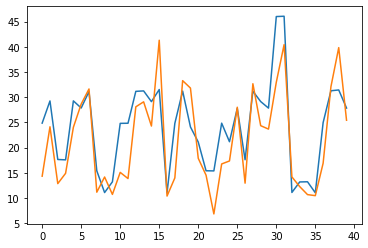

In [1008]:
y_predict = model.predict(X_train.T)
y_predict = np.squeeze(y_predict)
t = range(len(y_predict))
plt.plot(t[:40],y_predict[:40])
plt.plot(t[:40],y_train[:40])
plt.show()

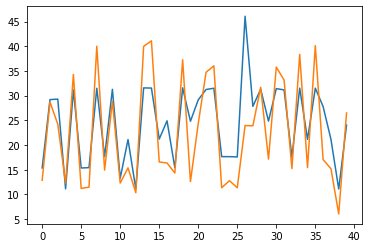

In [1009]:
y_predict = model.predict(X_test.T)
y_predict = np.squeeze(y_predict)
t = range(len(y_predict))
plt.plot(t[:40],y_predict[:40])
plt.plot(t[:40],y_test[:40])
plt.show()

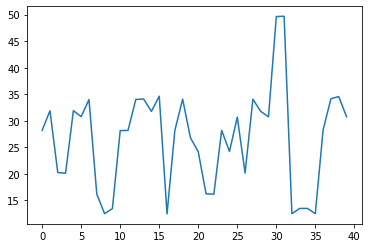

In [969]:
plt.plot(t[:40],y_predict[:40])
plt.show()